In [1]:
#pip install -U sckit-learn
#pip install psycopg2-binary
#pip install graphviz

import pandas as pd
import psycopg2
from path import Path
from sqlalchemy import create_engine
from config import db_password
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt

In [2]:
##Codeblock taken from Data Retreival
#Create our connection
connection_dic = {
    "host":"localhost",
    "database":"final_project",
    "user":"postgres",
    "password":db_password
}
def connect(connection_dic):
    #Connecting to the postgresql db server
    conn = None
    try:
        #connect to the server
        print('Connecting to the Final Project database...')
        conn = psycopg2.connect(**connection_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    print("Connection Successful!")
    return conn

In [3]:
def getdata (conn, select_query, column_names):
    #create our dataframe from db
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception,psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [4]:
#Grab the courses_df
conn = connect(connection_dic)
driver_cols = ["position","name","rarity","special_skill"]
courses_cols = ["name","is_reverse","is_trick"]
level1_cols = ["course_name","driver_id_1","special_skill_1","rarity_1","win_loss_1","driver_id_2","special_skill_2","rarity_2"
              "win_loss_2","driver_id_3","special_skill_3","rarity_3","win_loss_3",
              "driver_id_4","special_skill_4","rarity_4","win_loss_4",
              "driver_id_5","special_skill_5","rarity_5","win_loss_5"]
final_mk_cols = ["course_name","driver_id","name","rarity","special_skill","win_loss"]


# Grab the drivers data for our connection
sql_query = "select * from drivers"
drivers_df = getdata(conn, sql_query, driver_cols)


#Grab the courses data
sql_query = ("select * from courses")
courses_df = getdata(conn, sql_query, courses_cols)

# grab the level 1 driver course data
sql_query = ("select * from level1")
level1_df = getdata(conn, sql_query, level1_cols)

#grab the final data
sql_query = ("select * from final_mk")
df = getdata(conn,sql_query, final_mk_cols)

Connecting to the Final Project database...
Connection Successful!


In [5]:
conn.close()

In [6]:
#Importing Dataset
df

,course_name,driver_id,name,rarity,special_skill,win_loss
0,DS Waluigi Pinball,1,Baby Mario,Normal,Boomerang Flower,1
1,SNES Mario Circuit 1T,1,Baby Mario,Normal,Boomerang Flower,1
2,3DS Cheep Cheep Lagoon,2,Baby Peach,Normal,Bubble,1
3,3DS Daisy Hills R/T,2,Baby Peach,Normal,Bubble,1
4,3DS Daisy Hills T,3,Baby Daisy,Normal,Bubble,1
...,...,...,...,...,...,...
535,3DS Neo Bowser City T,102,Waluigi (Bus Driver),High-End,Triple Bananas,0
536,Vancouver Velocity R,104,Wario (Hiker),High-End,Bob-omb Cannon,0
537,GBA Bowser's Castle 2T,105,Dry Bones (Gold),High-End,Coin Box,0
538,DS Airship Fortress R,108,Dry Bowser (Gold),High-End,Bob-omb Cannon,0


In [7]:
#Remove driver_id column
df.drop(columns=['driver_id','name'], axis=1, inplace=True)
df

,course_name,rarity,special_skill,win_loss
0,DS Waluigi Pinball,Normal,Boomerang Flower,1
1,SNES Mario Circuit 1T,Normal,Boomerang Flower,1
2,3DS Cheep Cheep Lagoon,Normal,Bubble,1
3,3DS Daisy Hills R/T,Normal,Bubble,1
4,3DS Daisy Hills T,Normal,Bubble,1
...,...,...,...,...
535,3DS Neo Bowser City T,High-End,Triple Bananas,0
536,Vancouver Velocity R,High-End,Bob-omb Cannon,0
537,GBA Bowser's Castle 2T,High-End,Coin Box,0
538,DS Airship Fortress R,High-End,Bob-omb Cannon,0


In [8]:
#Check the datatypes
df.dtypes

course_name      object
rarity           object
special_skill    object
win_loss          int64
dtype: object

In [9]:
#Set win_loss as target
inputs = df

In [10]:
#Add Encoder Library
from sklearn.preprocessing import LabelEncoder

In [11]:
#Identify columns to encode
le_course_name = LabelEncoder()
le_name = LabelEncoder()
le_special_skill = LabelEncoder()
le_rarity = LabelEncoder()

In [12]:
#Encode columns, associate a number to text
inputs['course_name_new'] = le_course_name.fit_transform(inputs['course_name'])
inputs['rarity_new'] = le_rarity.fit_transform(inputs['rarity'])
inputs['special_skill_new'] = le_special_skill.fit_transform(inputs['special_skill'])
inputs.head()

,course_name,rarity,special_skill,win_loss,course_name_new,rarity_new,special_skill_new
0,DS Waluigi Pinball,Normal,Boomerang Flower,1,46,1,3
1,SNES Mario Circuit 1T,Normal,Boomerang Flower,1,147,1,3
2,3DS Cheep Cheep Lagoon,Normal,Bubble,1,0,1,5
3,3DS Daisy Hills R/T,Normal,Bubble,1,6,1,5
4,3DS Daisy Hills T,Normal,Bubble,1,7,1,5


In [13]:
#Remove course_name, name, special_skill & rarity
inputs_new = inputs.drop(['course_name', 'special_skill', 'rarity'],axis='columns')
inputs_new

,win_loss,course_name_new,rarity_new,special_skill_new
0,1,46,1,3
1,1,147,1,3
2,1,0,1,5
3,1,6,1,5
4,1,7,1,5
...,...,...,...,...
535,0,14,0,18
536,0,172,0,2
537,0,56,0,6
538,0,36,0,2


In [14]:
#Define the feature set
X = inputs_new.copy()
X = X.drop("win_loss", axis=1)
X.head()

,course_name_new,rarity_new,special_skill_new
0,46,1,3
1,147,1,3
2,0,1,5
3,6,1,5
4,7,1,5


In [15]:
#Define the target set
y = inputs_new["win_loss"].values.copy()
y[:3]

array([1, 1, 1], dtype=int64)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(405, 3)
(135, 3)
(405,)
(135,)


In [18]:
# Splitting into Train and Test sets into an 80/20 split.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=78, train_size=0.80)

In [19]:
# Determine the shape of our training and testing sets.
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(432, 3)
(108, 3)
(432,)
(108,)


In [20]:
import warnings 
warnings.filterwarnings("ignore")

In [21]:
#Removed this for now
# # Creating a StandardScaler instance.
# scaler = StandardScaler()
# # Fitting the Standard Scaler with the training data.
# X_scaler = scaler.fit(X_train)

# # Scaling the data.
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Creating the decision tree classifier instance.
dtc = tree.DecisionTreeClassifier(random_state = 1)
# Fitting the model.
model = dtc.fit(X_train, y_train)

In [27]:
predictions= model.predict(X_test)
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0], dtype=int64)

In [28]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,65,26
Actual 1,20,24


In [29]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [30]:
acc_score

0.6592592592592592

In [31]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,65,26
Actual 1,20,24


Classification Report
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        91
           1       0.48      0.55      0.51        44

    accuracy                           0.66       135
   macro avg       0.62      0.63      0.62       135
weighted avg       0.67      0.66      0.66       135



In [37]:
import pickle
pickle.dump(model,open('model.pkl','wb'))

In [39]:
model = pickle.load(open('model.pkl','rb'))

In [34]:
text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_1 <= 0.50
|   |--- feature_2 <= 11.50
|   |   |--- feature_2 <= 8.50
|   |   |   |--- feature_0 <= 173.50
|   |   |   |   |--- feature_0 <= 120.00
|   |   |   |   |   |--- feature_0 <= 105.50
|   |   |   |   |   |   |--- feature_0 <= 22.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_0 >  22.00
|   |   |   |   |   |   |   |--- feature_0 <= 27.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_0 >  27.00
|   |   |   |   |   |   |   |   |--- feature_0 <= 35.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 34.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_0 >  34.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_0 >  35.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 59.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_0 > 

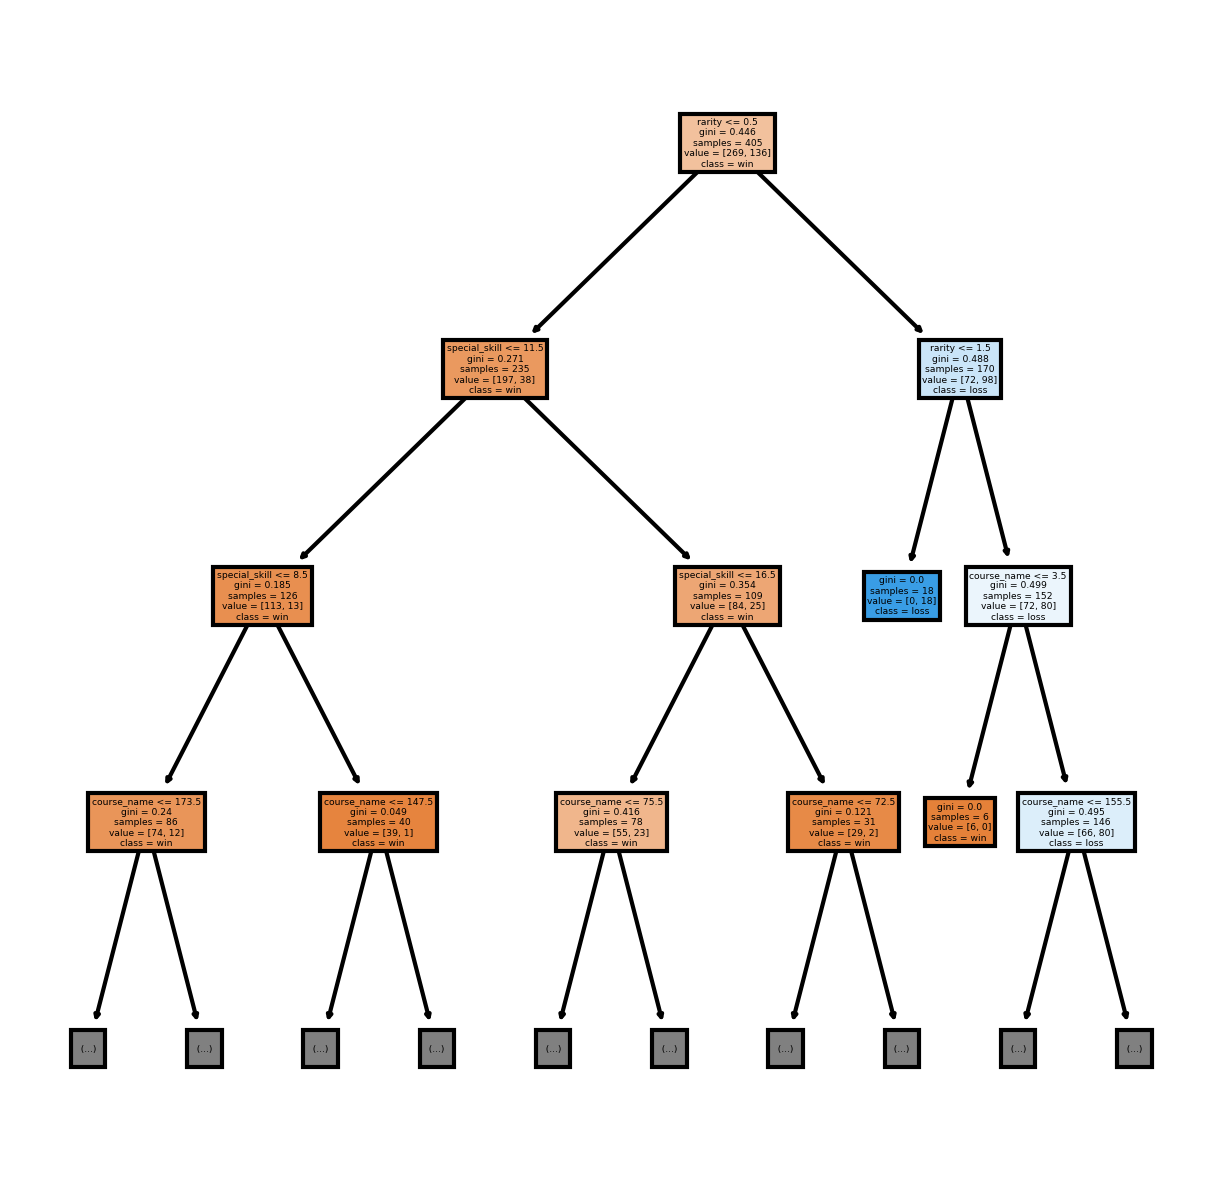

In [50]:
fn = ['course_name','rarity','special_skill']
cn=['win','loss']
fig, axes = plt.subplots(nrows=1,ncols=1,figsize =(5,5),dpi=300)
tree.plot_tree(dtc, feature_names=fn,class_names=cn, max_depth=3, filled=True)
plt.show()
fig.savefig('Resources/decisiontree.png')

In [ ]:
fig.savefig("decision_tree.png")

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)